In [4]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
info = pd.read_excel("data/NASCseq.xlsx")

# 1. Datasets summary

In [5]:
dat = pd.read_excel("data/NASCseq.xlsx")
dat = dat[dat["Method"] == "NASC-seq"]
dat = dat[[str(run).startswith("2022") for run in dat["Run"]]]
Counter([tuple(vs) for vs in dat[["s4U", "Time"]].values])

Counter({(0.0, 3.0): 39,
         (50.0, 3.0): 38,
         (500.0, 2.0): 13,
         (100.0, 3.0): 12,
         (200.0, 2.0): 12,
         (50.0, 2.0): 10,
         (100.0, 2.0): 10,
         (200.0, 3.0): 9})

# 2. Report summary

In [8]:
def str2int(s):
    return int(s.replace(",", ""))

rows = []
for run, cell in info[["Run", "Cell"]].values:
    # cutadapt
    total_reads = 0
    trimmed_reads = 0
    path = "results/prepare/cutadapt/%s/%s.1.log" % (run, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "Total reads processed:" in line or "Total read pairs processed:" in line:
                    total_reads = str2int(line.strip("\n").split()[-1])
                    break
    path = "results/prepare/cutadapt/%s/%s.2.log" % (run, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "Reads written (passing filters):" in line or "Pairs written (passing filters):" in line:
                    trimmed_reads = str2int(line.strip("\n").split()[-2])
                    break
                    
    # bowtie2
    rrna = 0
    path = "results/prepare/bowtie2/%s/%s.log" % (run, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "overall" in line:
                    rrna = float(line.split()[0][:-1])
                    
    # STAR
    uniq_mapped = 0
    path = "results/mapping/star/%s/%s/%s.Log.final.out" % (run, cell, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "Uniquely mapped reads %" in line:
                    uniq_mapped = float(line.strip("\n").split()[-1][:-1])
    
    # mark strand
    pos = 0
    neg = 0
    strand_perc = 0
    path = "results/mapping/marked_strand/%s/%s.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t")
        vs = d.iloc[0].values
        pos, neg = vs[1], vs[2]
        strand_perc = np.divide(sum(vs[1:3]), sum(vs[1:5]))
    
    # mismatch events
    pc = 0
    pe = 0
    signal = 0
    path = "results/mismatch/report/%s/%s/ratio.ce.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t", index_col=0)
        pc = d.loc["TC"]["Ratio"] * 100
        pe = np.mean(d.loc[["CT", "GA"]]["Ratio"]) * 100
        signal = np.divide(pc, pe)
        
    # nascent proportion
    path = "results/nascent/marked_nascent/%s/%s.tsv" % (run, cell)
    total = 0
    nascent = 0
    unknown = 0
    nascent_perc = 0
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t")
        total, nascent, unknown = d.iloc[0]
        nascent_perc = np.divide(nascent, total) * 100
        
    rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
                 rrna, uniq_mapped, 
                 pos, neg, strand_perc, 
                 pc, pe, signal,
                 total, nascent, nascent_perc
                ])        
    
df = pd.DataFrame(rows)
df.columns = ["Total.Reads", "Trimmed.Reads", "Trimmed.Reads.Ratio", 
              "RiboRNA.Ratio", "UniqMapped.Ratio", 
              "Forward", "Reverse", "Stranded.Ratio", 
              "Pc", "Pe", "PcPe.Ratio", 
              "RNAs", "NascentRNA", "NascentRNA.Ratio"]
dat = pd.concat([info, df], axis=1)
dat.head()

/home/chenzonggui/tmp/ipykernel_6725/1718913390.py:75: RuntimeWarning: invalid value encountered in divide
  rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
/home/chenzonggui/tmp/ipykernel_6725/1718913390.py:75: RuntimeWarning: invalid value encountered in divide
  rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
/home/chenzonggui/tmp/ipykernel_6725/1718913390.py:75: RuntimeWarning: invalid value encountered in divide
  rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
/home/chenzonggui/tmp/ipykernel_6725/1718913390.py:75: RuntimeWarning: invalid value encountered in divide
  rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
/home/chenzonggui/tmp/ipykernel_6725/1718913390.py:75: RuntimeWarning: invalid value encountered in divide
  rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
/home/chenzonggui/tmp/ipy

,Run,Cell,CellLine,s4U,Time,Method,Layout,Strand,Species,Total.Reads,...,UniqMapped.Ratio,Forward,Reverse,Stranded.Ratio,Pc,Pe,PcPe.Ratio,RNAs,NascentRNA,NascentRNA.Ratio
0,20220113_NASCseq_K562,20220113_02_02,K562,0,3.0,NASC-seq,PE,UN,Human,0,...,78.01,514485,481152,0.967472,0,0,0,0,0,0
1,20220113_NASCseq_K562,20220113_02_04,K562,0,3.0,NASC-seq,PE,UN,Human,0,...,80.01,641701,610923,0.968862,0,0,0,0,0,0
2,20220113_NASCseq_K562,20220113_02_05,K562,0,3.0,NASC-seq,PE,UN,Human,0,...,80.39,789782,770922,0.972155,0,0,0,0,0,0
3,20220113_NASCseq_K562,20220113_02_07,K562,0,3.0,NASC-seq,PE,UN,Human,0,...,76.41,322272,312558,0.963103,0,0,0,0,0,0
4,20220113_NASCseq_K562,20220113_02_08,K562,0,3.0,NASC-seq,PE,UN,Human,0,...,84.69,730270,728368,0.959826,0,0,0,0,0,0


In [3]:
# load expression
data = dict()
for run, cell in infos[["Run", "Cell"]].values:
    path = "results/nascent/expression/annotated/%s/%s.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t")
        d = d[d["Canonical"]]
        d = d[(d["GeneType"] == "protein_coding") | (d["GeneType"] == "lncRNA")]
        data[cell] = d

In [4]:
rows = []
for run, cell in infos[["Run", "Cell"]].values:
    protein_coding = 0
    protein_coding_nascent = 0
    lncRNA = 0
    lncRNA_nascent = 0
    if cell in data:
        d = data[cell]
        d1 = d[d["GeneType"] == "protein_coding"]
        d2 = d1[d1["FPKM"] >= 1]
        d3 = d1[(d1["FPKM[Nascent]"] >= 1) & (d1["Count[Nascent]"] >= 1)]
        protein_coding = len(set(d2["GeneName"]))
        protein_coding_nascent = len(set(d3["GeneName"]))
        
        d1 = d[d["GeneType"] == "lncRNA"]
        d2 = d1[d1["FPKM"] >= 1]
        d3 = d1[d1["FPKM[Nascent]"] >= 1]
        lncRNA = len(set(d2["GeneName"]))
        lncRNA_nascent = len(set(d3["GeneName"]))
    rows.append([protein_coding, protein_coding_nascent, lncRNA, lncRNA_nascent])

In [5]:
df = pd.DataFrame(rows)
df.columns = ["Protein_coding", "Protein_coding[Nascent]", "lncRNA", "lncRNA[Nascent]"]
dat1 = pd.concat([dat, df], axis=1)
dat1.head()

,Run,Cell,Strain,4sU,Time,Method,Layout,Strand,Species,Cells,...,Pc,Pe,SignalToNoise,RNAs,NascentRNA,NascentRNA%,Protein_coding,Protein_coding[Nascent],lncRNA,lncRNA[Nascent]
0,20220113,20220113_02_02,K562,0.0,3,NASC-seq,PE,UN,Human,1.0,...,0.054199,0.054076,1.002270,1374412,21665,1.576310,5489,1036,400,29
1,20220113,20220113_02_04,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.046281,0.053467,0.865600,1811418,27369,1.510916,4242,897,230,29
2,20220113,20220113_02_05,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.044695,0.048489,0.921765,2218621,34081,1.536134,4458,824,257,21
3,20220113,20220113_02_07,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.077170,0.055532,1.389636,788602,19423,2.462966,4575,1132,289,45
4,20220113,20220113_02_08,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.051876,0.047762,1.086117,2054641,46885,2.281907,6559,1389,467,31


In [6]:
dat1.to_excel("data/NASCseq_summary.xlsx", index=False)

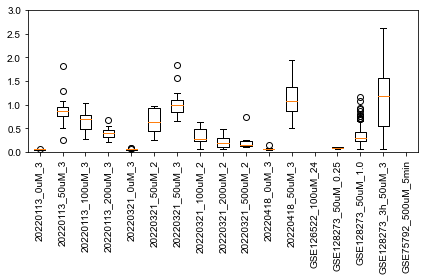

In [43]:
names = []
array = []
for run, d1 in dat1.groupby(by="Run"):
    for s4u, d2 in d1.groupby(by="4sU"):
        for time, d3 in d2.groupby(by="Time"):
            # print(run, s4u, time, len(d3), sep="\t")
            name = "%s_%duM_%s" % (run, s4u, time)
            names.append(name)
            array.append(d3["Pc"].values)
xs = np.arange(len(array))

plt.figure()
plt.boxplot(array, positions=xs)
plt.xticks(xs, names, rotation=90)
plt.ylim(0, 3)
plt.tight_layout()
plt.show()

# Mismatch ratio

In [16]:
d = infos[(infos["Strain"] == "K562") & (infos["4sU"] == 0) & (infos["Time"] == 3)]
print(len(d))

39


In [28]:
array = []
for run, cell in d[["Run", "Cell"]].values:
    path = "results/nascent/ratio/%s/%s.tsv" % (run, cell)
    tmp = pd.read_csv(path, sep="\t", index_col=0)
    if tmp["BaseCount"].values[0] < 40000000:
        print(0)
    s = tmp["Ratio[NoSNP]"]
    s.name = cell
    array.append(s)
df = pd.concat(array, axis=1).T

0
0


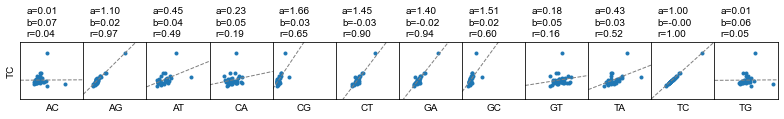

In [53]:
mtypes = ['AC', 'AG', 'AT', 'CA', 'CG', 'CT', 'GA', 'GC', 'GT', 'TA', 'TC', 'TG']
vmax = 0.2
fig, axs = plt.subplots(1, 12, figsize=(11, 2.2), gridspec_kw=dict(wspace=0), sharex=True, sharey=True)
for i, mtype in enumerate(mtypes):
    xs = df[mtype] * 100
    # xs = df[["GA", "CT"]].mean(axis=1) * 100
    ys = df["TC"] * 100
    a, b = np.polyfit(xs, ys, 1)
    r = np.corrcoef(xs, ys)[0][1]
    
    plt.sca(axs[i])
    plt.scatter(xs, ys, marker=".")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(mtype)
    if i == 0:
        plt.ylabel("TC")
    plt.xlim(0, vmax)
    plt.ylim(0, vmax)
    plt.plot([0, vmax], [b, a * vmax + b], lw=1, ls="--", color="grey")
    plt.text(vmax * 0.1, vmax * 1.5, "a=%.2f" % a)
    plt.text(vmax * 0.1, vmax * 1.3, "b=%.2f" % b)
    plt.text(vmax * 0.1, vmax * 1.1, "r=%.2f" % r)
    
plt.tight_layout()
plt.show()

# 20231129

In [1]:
import pandas as pd

In [2]:
snp_positions = pd.read_csv("results/reproduced/QC/vcfFilter/posfile.csv", index_col=0, header=0)
snp_positions

,chrom,pos2
1,chrX,46440464
2,chrX,74173975
3,chrX,74173986
4,chrX,39787606
5,chrX,39787107
...,...,...
9701,chr12,56042579
9702,chrM,9272
9703,chr22,40826396
9704,chr2,216499387


In [10]:
read_snp_positions = set(snp_positions[snp_positions['chrom'] == "chr1"]['pos2'][snp_positions[snp_positions['chrom'] == "chr1"]['pos2'].between(101000000, 160000000)])

In [11]:
read_snp_positions

{107505163,
 107505208,
 107505433,
 107505487,
 107505515,
 107505538,
 108639255,
 108992438,
 108992583,
 108992630,
 109030218,
 109231717,
 109235380,
 109236434,
 109275215,
 109401934,
 109401940,
 109401946,
 109402053,
 109409976,
 109411929,
 109629444,
 109659076,
 111440529,
 111459586,
 111461071,
 111461186,
 111461296,
 111461325,
 112671351,
 112911948,
 112912904,
 112912909,
 112912918,
 112917930,
 112917932,
 113093241,
 113093243,
 113907039,
 113977485,
 114405658,
 114717512,
 117950019,
 117959474,
 117959479,
 117959483,
 117959486,
 145112466,
 145290799,
 145623151,
 145992654,
 145992677,
 146065412,
 147083131,
 147083301,
 147083436,
 147083472,
 147178928,
 147179392,
 147203754,
 147203821,
 147204063,
 147204098,
 147204111,
 147204527,
 147943535,
 148532099,
 148929200,
 149032958,
 149832976,
 149842229,
 149842329,
 149842348,
 149842368,
 149842408,
 149842417,
 149842435,
 149842441,
 149842455,
 149842485,
 149842510,
 149842539,
 149842580,
 149

In [18]:
dat = pd.read_csv("../public/NASC-seq/data/posfile.csv", header=0, index_col=0)
array = []
for x in dat["chrom"]:
    if not x.startswith("ERCC"):
        x = "chr%s" % x
    array.append(x)
dat["chrom"] = array
dat.to_csv("../public/NASC-seq/data/posfile.chr.csv")

# 20231207

In [91]:
data = dict()
import glob
for path in glob.glob("results/nascent/estimate_pc/*/*.tsv"):
    cell = path.split("/")[-1][:-4]
    d = pd.read_csv(path, sep="\t", header=0)
    pe, pc, s2n = d.iloc[0]
    data[cell] = [pe, pc, s2n]

In [104]:
d = info[["2022" in run for run in info["Run"]]]
d = d[d["Layout"] == "PE"]
print("s4U\tTime\tCells\tMean\tMedian")
for s4u, d1 in d.groupby(by="s4U"):
    for time, d2 in d1.groupby(by="Time"):
        vs = [data[cell][2] for cell in d2["Cell"]]
        print(s4u, time, len(d2), round(np.mean(vs), 2), round(np.median(vs), 2), sep="\t")

s4U	Time	Cells	Mean	Median
0	3.0	39	1.17	1.16
50	2.0	10	49.09	54.54
50	3.0	38	67.01	71.53
100	2.0	10	40.78	45.98
100	3.0	12	74.86	76.21
200	2.0	12	20.82	10.93
200	3.0	9	62.76	67.28
500	2.0	13	16.4	4.44


In [105]:
d = info[["2022" not in run for run in info["Run"]]]
d = d[d["Layout"] == "PE"]
print("s4U\tTime\tCells\tMean\tMedian")
for s4u, d1 in d.groupby(by="s4U"):
    for time, d2 in d1.groupby(by="Time"):
        vs = [data[cell][2] for cell in d2["Cell"]]
        print(s4u, time, len(d2), round(np.mean(vs), 2), round(np.median(vs), 2), sep="\t")

s4U	Time	Cells	Mean	Median
50	0.25	46	1.27	1.23
50	1.0	142	14.19	11.32


# Model for estimating Pe

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
info = pd.read_excel("data/NASCseq.xlsx")
d = info
d = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Layout"] == "PE") & (d["Cells"] == 1)]
# d = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Layout"] == "SE")]
print(len(d))

37


In [81]:
array = []
for run, cell in d[["Run", "Cell"]].values:
    path = "results/mismatch/ratio/%s/%s.tsv" % (run, cell)
    m = pd.read_csv(path, sep="\t", header=0, index_col=0)
    m = m[["-" not in t for t in m.index]]
    s = m["Ratio[NoSNP]"]
    s.name = cell
    array.append(s)
m = pd.DataFrame(array)
m.index.name = "Cell"

Type	K	R
AC	0.9196	0.0795
AG	1.4649	0.8781
AT	1.2643	0.4174
CA	0.9034	0.0906
CG	3.54	0.524
CT	0.9282	0.7013
GA	1.0419	0.796
GC	2.3715	0.5269
GT	0.5839	0.1386
TA	0.8458	0.4732
TC	1.0	1.0
TG	0.5627	0.0986


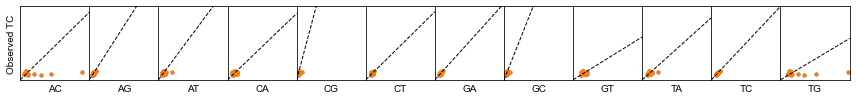

Model:
  Type         K         R         W
1   AG  1.464863  0.878086  0.369663
5   CT  0.928208  0.701265  0.295223
6   GA  1.041946  0.796019  0.335114
Custom strategy:
K: 0.9984, R: 0.8756


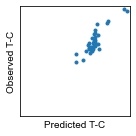

NASC-seq strategy:
K: 0.9816, R: 0.7616


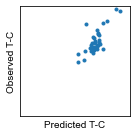

GRAND-SLAM strategy:
K: 0.6650, R: 0.1651


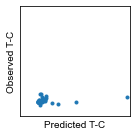

In [82]:
mtypes = []
bases = "ACGT"
for ref in bases:
    for alt in bases:
        if ref != alt:
            mtypes.append("%s%s" % (ref, alt))

lim = m.max().max() * 1.02
fig, axs = plt.subplots(1, 12, figsize=(12, 1.5), sharex=True, sharey=True, gridspec_kw=dict(wspace=0))
rows = []
print("Type\tK\tR")
for i, mtype in enumerate(mtypes):
    ax = axs[i]
    plt.sca(ax)
    xs = m[mtype]
    ys = m["TC"]

    flags = (xs > lim * 0) & (ys > lim * 0)
    xs1 = xs[flags]
    ys1 = ys[flags]

    r = np.corrcoef(xs1, ys1)[0][1]
    k = np.e ** ((sum(np.log(ys1)) - sum(np.log(xs1))) / len(xs1))
    print(mtype, round(k, 4), round(r, 4),sep="\t")
    rows.append([mtype, k, r])

    plt.scatter(xs, ys, marker=".")
    plt.scatter(xs1, ys1, marker=".")
    plt.plot([0, lim], [0, lim * k], lw=1, ls="--", color="black")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(mtype)
    if i == 0:
        plt.ylabel("Observed TC")

plt.tight_layout()
plt.show()

model = pd.DataFrame(rows, columns=["Type", "K", "R"])
model = model[(model["Type"] != "TC") & (model["R"] >= 0.6)]
model["W"] = model["R"] / model["R"].sum()
model.to_csv("results/mismatch/Estimate.Pe.Model.K562.PE.tsv", sep="\t", index=False)
print("Model:")
print(model)

array = []
for t, k, r, w in model.values:
    array.append(m[t] * k * w)
m1 = m.copy()
m1["Pe"] = pd.DataFrame(array).sum(axis=0)

print("Custom strategy:")
xs = m1["Pe"]
ys = m1["TC"]
lim = max(max(xs), max(ys)) * 1.02
r = np.corrcoef(xs, ys)[0][1]
k = np.e ** ((sum(np.log(ys)) - sum(np.log(xs))) / len(xs))
print("K: %.4f, R: %.4f" % (k, r))
plt.figure(figsize=(2, 2))
plt.scatter(xs, ys, marker=".")
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel("Predicted T-C")
plt.ylabel("Observed T-C")
plt.tight_layout()
plt.show()
plt.close()

print("NASC-seq strategy:")
xs = (m1["CT"] + m1["GA"])/2
ys = m1["TC"]
lim = max(max(xs), max(ys)) * 1.02
r = np.corrcoef(xs, ys)[0][1]
k = np.e ** ((sum(np.log(ys)) - sum(np.log(xs))) / len(xs))
print("K: %.4f, R: %.4f" % (k, r))
plt.figure(figsize=(2, 2))
plt.scatter(xs, ys, marker=".")
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel("Predicted T-C")
plt.ylabel("Observed T-C")
plt.tight_layout()
plt.show()
plt.close()

print("GRAND-SLAM strategy:")
xs = (m1["TA"] + m1["TG"])/2
ys = m1["TC"]
lim = max(max(xs), max(ys)) * 1.02
r = np.corrcoef(xs, ys)[0][1]
k = np.e ** ((sum(np.log(ys)) - sum(np.log(xs))) / len(xs))
print("K: %.4f, R: %.4f" % (k, r))
plt.figure(figsize=(2, 2))
plt.scatter(xs, ys, marker=".")
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel("Predicted T-C")
plt.ylabel("Observed T-C")
plt.tight_layout()
plt.show()
plt.close()